Load the WalabotSDK from source.

In [1]:
from imp import load_source
WalabotAPI = load_source('WalabotAPI', 'C:/Program Files/Walabot/WalabotSDK/python/WalabotAPI.py')
import WalabotAPI as wb

Initialize the Walabot SDK and set the arena.

In [2]:
# Select scan arena
# Each value is (min, max, cm resolution)
#             R             Phi          Theta
ARENA = [(10, 100, 4), (-30, 30, 4), (-30, 30, 4)]

from time import sleep
import sys
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import k3d
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

print("Initialize API")
wb.Init()
wb.Initialize()

# Check if a Walabot is connected
try:
    wb.ConnectAny()

except wb.WalabotError as err:
    print("Failed to connect to Walabot.\nerror code: " + str(err.code))

ver = wb.GetVersion()
print("Walabot API version: {}".format(ver))

print("Connected to Walabot")
wb.SetProfile(wb.PROF_SENSOR)

# Set scan arena
wb.SetArenaR(*ARENA[0])
wb.SetArenaPhi(*ARENA[1])
wb.SetArenaTheta(*ARENA[2])
print("Arena set")

# Set image filter
wb.SetDynamicImageFilter(wb.FILTER_TYPE_NONE)

# Start scan
wb.Start()

Initialize API
Walabot API version: 1.2.2_1a20f5edc5cf4fada3b3002990052a300279b7f8
Connected to Walabot
Arena set


In [3]:
def pos_map_3d(arena, img):
    """
    Given an arena and a raw image, return the 3D positions of all the points.
    This function might be wrong.
    """
    r_range, phi_range, theta_range = arena
    ni, nj, nk = img.shape
    positions = []
    for theta,phi,r in product(np.linspace(*theta_range[:2], ni),
                               np.linspace(*phi_range[:2], nj),
                               np.linspace(*r_range[:2], nk)):
        theta = np.deg2rad(theta)
        phi = np.deg2rad(phi)
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        positions.append((x, y, z))
    return positions

In [4]:
def get_frame():
    """
    Trigger the Walabot, return a raw image and colors.
    """
    wb.Trigger()
    raw, ni, nj, nk, max_power = wb.GetRawImage()
    raw = np.asarray(raw)
    img = raw.astype(np.float32) / 255
    grayscale = np.asarray([(e<<16) + (e<<8) + e for e in range(256)], dtype=np.uint32)
    colors = grayscale[255 - raw.reshape(-1).astype(np.uint8)]
    return img, colors

plot = k3d.plot()
img, colors = get_frame()
posmap = pos_map_3d(ARENA, img)
points = k3d.points(positions=posmap, shader='flat', colors=colors, opacity=0.5)
plot += points
plot.display()

while True:
    try:
        img, colors = get_frame()
        points.colors = colors
        sleep(0.05)
    except KeyboardInterrupt:
        break

Output()

Set up our dictionary that will collect recorded samples. Run this cell again to clear the recorded samples.

In [8]:
samples = defaultdict(list)

def record_samples(category, total=256):
    for i in range(total):
        try:
            img, colors = get_frame()
            samples[category].append(img)
            n = len(samples[category])
            pct = n / total
            print(f'{category}: {n}/{total} {100*pct:.2f}%')
            sleep(0.01)
            clear_output(wait=True)
        except KeyboardInterrupt:
            break

Record samples for the "close" category.

In [9]:
record_samples('close')

close: 256/256 100.00%


Record samples for the "far" category.

In [10]:
record_samples('far')

far: 256/256 100.00%


Collect all the samples into one array and generate the ground truth labels. Then divide into a 10% test and 90% train split.

In [11]:
keys = list(samples.keys())
x_a = np.stack(samples[keys[0]])
x_b = np.stack(samples[keys[1]])
x = np.vstack((x_a, x_b))
x = x.reshape(len(x), -1)

a_n = len(samples[keys[0]])
b_n = len(samples[keys[1]])
y = np.asarray([0] * a_n + [1] * b_n).astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

Train a simple neural network to predict the distance category and test it on the test set. This should acheive aroudn 98%+ accuracy

In [12]:
nn = MLPClassifier()
nn.fit(x_train, y_train)
y_pred = nn.predict_proba(x_test)
accuracy = nn.score(x_test, y_test)
print(f'{100*accuracy:.2f}% accuracy')

100.00% accuracy


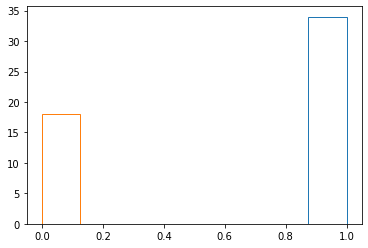

In [13]:
plt.hist(y_pred[:,0][y_test==0], bins=8, range=(0,1), histtype='step')
plt.hist(y_pred[:,0][y_test==1], bins=8, range=(0,1), histtype='step')
plt.show()

Run this cell to evaluate the model in realtime.

In [14]:
while True:
    try:
        img, colors = get_frame()
        which = nn.predict_proba([img.reshape(-1)])[0,1]
        length = 50
        n = int(which * length)
        label = '='*n + '|' + '-'*(length-1-n)
        output = f'{keys[0]} {label} {keys[1]}'
        print(output)
        sleep(0.03)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break

close =================================================| far


In [44]:
wb.Stop()
wb.Disconnect()
wb.Clean()

Done!
